<a href="https://colab.research.google.com/github/microsoft/autogen/blob/main/notebook/agentchat_function_call.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Auto Generated Agent Chat: Task Solving with Provided Tools as Functions

AutoGen offers conversable agents powered by LLM, tool, or human, which can be used to perform tasks collectively via automated chat. This framework allows tool use and human participation through multi-agent conversation. Please find documentation about this feature [here](https://microsoft.github.io/autogen/docs/Use-Cases/agent_chat).

In this notebook, we demonstrate how to use `AssistantAgent` and `UserProxyAgent` to make function calls with the new feature of OpenAI models (in model version 0613). A specified prompt and function configs must be passed to `AssistantAgent` to initialize the agent. The corresponding functions must be passed to `UserProxyAgent`, which will execute any function calls made by `AssistantAgent`. Besides this requirement of matching descriptions with functions, we recommend checking the system message in the `AssistantAgent` to ensure the instructions align with the function call descriptions.

## Requirements

AutoGen requires `Python>=3.8`. To run this notebook example, please Install `autogen-agentchat`:
```bash
pip install autogen-agentchat~=0.2
```

In [10]:
# %pip install "autogen-agentchat~=0.2"

## Set your API Endpoint

The [`config_list_from_json`](https://microsoft.github.io/autogen/docs/reference/oai/openai_utils#config_list_from_json) function loads a list of configurations from an environment variable or a json file.

In [11]:
from IPython import get_ipython
from typing_extensions import Annotated

import autogen
from autogen.cache import Cache

config_list = autogen.config_list_from_json(
    "OAI_CONFIG_LIST",
    filter_dict={"tags": ["tool"]},  # comment out to get all
)

It first looks for environment variable "OAI_CONFIG_LIST" which needs to be a valid json string. If that variable is not found, it then looks for a json file named "OAI_CONFIG_LIST". It filters the configs by tags (you can filter by other keys as well). Only the configs with matching tags are kept in the list based on the filter condition.

The config list looks like the following:
```python
config_list = [
    {
        'model': 'gpt-4',
        'api_key': '<your OpenAI API key here>',
        'tags': ['tool', 'gpt-4'],
    },
    {
        'model': 'gpt-3.5-turbo',
        'api_key': '<your Azure OpenAI API key here>',
        'base_url': '<your Azure OpenAI API base here>',
        'api_type': 'azure',
        'api_version': '2024-02-01
        'tags': ['tool', 'gpt-3.5-turbo'],
    },
    {
        'model': 'gpt-3.5-turbo-16k',
        'api_key': '<your Azure OpenAI API key here>',
        'base_url': '<your Azure OpenAI API base here>',
        'api_type': 'azure',
        'api_version': '2024-02-01
        'tags': ['tool', 'gpt-3.5-turbo-16k'],
    },
]
```

You can set the value of config_list in any way you prefer. Please refer to this [notebook](https://github.com/microsoft/autogen/blob/main/website/docs/topics/llm_configuration.ipynb) for full code examples of the different methods.

## Making Function Calls

In this example, we demonstrate function call execution with `AssistantAgent` and `UserProxyAgent`. With the default system prompt of `AssistantAgent`, we allow the LLM assistant to perform tasks with code, and the `UserProxyAgent` would extract code blocks from the LLM response and execute them. With the new "function_call" feature, we define functions and specify the description of the function in the OpenAI config for the `AssistantAgent`. Then we register the functions in `UserProxyAgent`.


In [12]:
llm_config = {
    "config_list": config_list,
    "timeout": 120,
}
chatbot = autogen.AssistantAgent(
    name="chatbot",
    system_message="For coding tasks, only use the functions you have been provided with. Reply TERMINATE when the task is done.",
    llm_config=llm_config,
)

# create a UserProxyAgent instance named "user_proxy"
user_proxy = autogen.UserProxyAgent(
    name="user_proxy",
    is_termination_msg=lambda x: x.get("content", "") and x.get("content", "").rstrip().endswith("TERMINATE"),
    human_input_mode="NEVER",
    max_consecutive_auto_reply=10,
    code_execution_config={
        "work_dir": "coding",
        "use_docker": False,
    },  # Please set use_docker=True if docker is available to run the generated code. Using docker is safer than running the generated code directly.
)


# define functions according to the function description


# one way of registering functions is to use the register_for_llm and register_for_execution decorators
@user_proxy.register_for_execution()
@chatbot.register_for_llm(name="python", description="run cell in ipython and return the execution result.")
def exec_python(cell: Annotated[str, "Valid Python cell to execute."]) -> str:
    ipython = get_ipython()
    result = ipython.run_cell(cell)
    log = str(result.result)
    if result.error_before_exec is not None:
        log += f"\n{result.error_before_exec}"
    if result.error_in_exec is not None:
        log += f"\n{result.error_in_exec}"
    return log


# another way of registering functions is to use the register_function
def exec_sh(script: Annotated[str, "Valid Python cell to execute."]) -> str:
    return user_proxy.execute_code_blocks([("sh", script)])


autogen.agentchat.register_function(
    exec_python,
    caller=chatbot,
    executor=user_proxy,
    name="sh",
    description="run a shell script and return the execution result.",
)

Finally, we initialize the chat that would use the functions defined above:

user_proxy (to chatbot):

Draw two agents chatting with each other with an example dialog. Don't add plt.show().

--------------------------------------------------------------------------------
chatbot (to user_proxy):

***** Suggested tool call (call_BiLzujDvfB7WMZ0hqcgBdjN2): python *****
Arguments: 
{"cell":"import matplotlib.pyplot as plt\nimport numpy as np\n\n# Create a simple representation of two agents\nagent1_x, agent1_y = [1, 2], [1, 1]\nagent2_x, agent2_y = [4, 3], [1, 1]\n\n# Create dialog bubbles\nbubble1_x = np.linspace(1.5, 2.5, 100)\nbubble1_y = np.sin(np.pi * (bubble1_x - 1.5)) + 1.2\nbubble2_x = np.linspace(3.5, 2.5, 100)\nbubble2_y = np.sin(np.pi * (bubble2_x - 2.5)) + 1.2\n\n# Drawing agents and dialog bubbles\nplt.figure(figsize=(6, 3))\nplt.plot(agent1_x, agent1_y, 'ko-', markersize=20)\nplt.plot(agent2_x, agent2_y, 'ko-', markersize=20)\nplt.plot(bubble1_x, bubble1_y, 'k')\nplt.plot(bubble2_x, bubble2_y, 'k')\nplt.fill_between(bubble1_x, 1, bubble1_y, color = '

(0.0, 5.0, 0.0, 2.5)

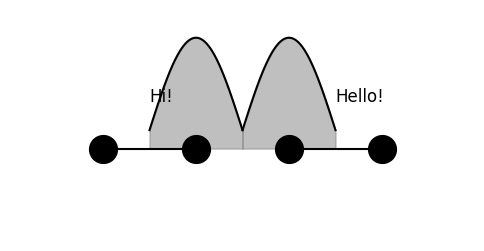

user_proxy (to chatbot):

user_proxy (to chatbot):

***** Response from calling tool (call_BiLzujDvfB7WMZ0hqcgBdjN2) *****
(0.0, 5.0, 0.0, 2.5)
**********************************************************************

--------------------------------------------------------------------------------
chatbot (to user_proxy):

I've drawn two agents chatting with each other, including example dialogues saying "Hi!" and "Hello!" within their speech bubbles. This visualization is created using matplotlib, and the conversation is represented graphically with the agents and their dialogue bubbles placed on a 2D plot. The drawing does not include `plt.show()`, adhering to your instruction.

--------------------------------------------------------------------------------
user_proxy (to chatbot):



--------------------------------------------------------------------------------
chatbot (to user_proxy):

It seems your last message was empty. How can I assist you further?

---------------------------

In [13]:
with Cache.disk() as cache:
    # start the conversation
    user_proxy.initiate_chat(
        chatbot,
        message="Draw two agents chatting with each other with an example dialog. Don't add plt.show().",
        cache=cache,
        max_turns=3,
    )